In [18]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)

In [19]:
def cooling_law(time, Tenv, T0, R):
    T = Tenv + (T0 - Tenv) * np.exp(-R * time)
    return T

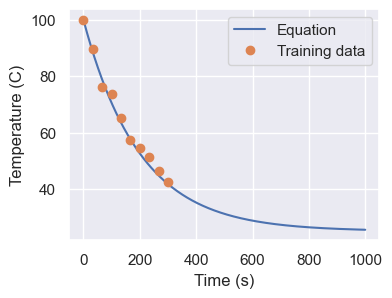

In [20]:
Tenv = 25
T0 = 100
R = 0.005
times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 300, 10)
T = eq(t) +  2 * np.random.randn(10)

plt.figure(figsize=(4, 3))
plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')
plt.show()

In [21]:
def grad(outputs, inputs):
    """ Computes the partial derivative of 
    an output wrt an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)
    
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R*(Tenv - temps) - dT
    return torch.mean(pde**2)

In [36]:
def np_to_th(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)

class Net(nn.Module):
    def __init__(self, input_dim, output_dim, n_units=100, epochs=100, loss=nn.MSELoss(), lr=1e-3, loss2=None, loss2_weight=0.1) -> None:
        super().__init__()
        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)
        
    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)
        return out
        
    def fit(self, X, y):
        Xt = np_to_th(X)
        yt = np_to_th(y)
        
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []
        for ep in range(self.epochs):
            optimizer.zero_grad()
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2:
                loss += self.loss2_weight + self.loss2_weight * self.loss2(self)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            if ep % 500 == 0:
                print(f'Epoch {ep}/{self.epochs}, Loss: {loss.item()}')
        return losses
    
    def predict(self, X):
        self.eval()
        out = self.forward(np_to_th(X))
        return out.detach().cpu().numpy()
    

In [39]:
net = Net(1,1,loss2=physics_loss, loss2_weight=1, epochs=30000, lr=1e-5).to(DEVICE)
losses = net.fit(t, T)

Epoch 0/30000, Loss: 4102.111328125
Epoch 500/30000, Loss: 2565.747314453125
Epoch 1000/30000, Loss: 2520.846435546875
Epoch 1500/30000, Loss: 2500.65185546875
Epoch 2000/30000, Loss: 2463.110595703125
Epoch 2500/30000, Loss: 2373.9482421875
Epoch 3000/30000, Loss: 2252.725830078125
Epoch 3500/30000, Loss: 2029.6146240234375
Epoch 4000/30000, Loss: 1691.5509033203125
Epoch 4500/30000, Loss: 1233.4576416015625
Epoch 5000/30000, Loss: 793.65283203125
Epoch 5500/30000, Loss: 384.0140380859375
Epoch 6000/30000, Loss: 141.342529296875
Epoch 6500/30000, Loss: 25.455657958984375
Epoch 7000/30000, Loss: 8.875807762145996
Epoch 7500/30000, Loss: 5.411595344543457
Epoch 8000/30000, Loss: 4.456297874450684
Epoch 8500/30000, Loss: 3.434908866882324
Epoch 9000/30000, Loss: 3.3570003509521484
Epoch 9500/30000, Loss: 3.2910425662994385
Epoch 10000/30000, Loss: 3.2419471740722656
Epoch 10500/30000, Loss: 3.18149733543396
Epoch 11000/30000, Loss: 3.1268649101257324
Epoch 11500/30000, Loss: 3.0746142864

Text(0.5, 0, 'Time (s)')

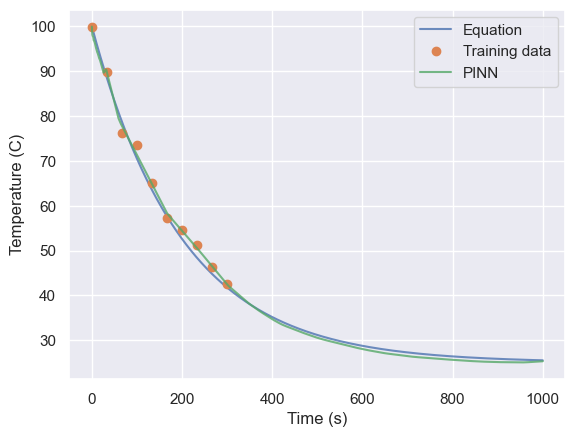

In [40]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')